# Carbon Intensity Forecasting (Germany) — Task 1

**Goal:** Predict the next **24 hours** of carbon intensity (gCO₂/kWh) from historical hourly data for Germany (DE).

**Deliverables in this notebook**
- Load & visualize data
- Train and validate models (baseline, XGBoost, MINN)
- Predict next 24 hours
- Evaluate vs baseline (MAE/RMSE), discuss results
- Brief reasoning & conclusions


In [1]:
import sys, numpy, pandas, sklearn
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import tensorflow as tf
except Exception:
    tf = None

print("Python", sys.version)
print("numpy", numpy.__version__, "| pandas", pandas.__version__, "| scikit-learn", sklearn.__version__)
print("xgboost", getattr(xgb, "__version__", "not installed"), "| tensorflow", getattr(tf, "__version__", "not installed"))


Python 3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
numpy 1.23.5 | pandas 2.0.3 | scikit-learn 1.3.0
xgboost 2.1.4 | tensorflow 2.10.0


In [2]:
import numpy as np, pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import random
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json("carbon-intensity.json")
df.head()

,carbonIntensityAvg,carbonIntensityHourly,startOfDay,endOfDay,timezone
0,174.125000,"[229, 259, 231, 227, 192, 209, 212, 201, 185, ...",2024-12-31T23:00:00.000Z,2025-01-01T22:59:00.000Z,Europe/Berlin
1,323.000000,"[142, 138, 175, 198, 221, 244, 258, 264, 273, ...",2025-01-01T23:00:00.000Z,2025-01-02T22:59:00.000Z,Europe/Berlin
2,327.083333,"[374, 378, 368, 355, 349, 357, 335, 317, 310, ...",2025-01-02T23:00:00.000Z,2025-01-03T22:59:00.000Z,Europe/Berlin
3,478.750000,"[376, 312, 325, 434, 459, 487, 524, 540, 536, ...",2025-01-03T23:00:00.000Z,2025-01-04T22:59:00.000Z,Europe/Berlin
4,331.916667,"[506, 486, 486, 480, 452, 439, 415, 402, 381, ...",2025-01-04T23:00:00.000Z,2025-01-05T22:59:00.000Z,Europe/Berlin


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   carbonIntensityAvg     180 non-null    float64
 1   carbonIntensityHourly  180 non-null    object 
 2   startOfDay             181 non-null    object 
 3   endOfDay               181 non-null    object 
 4   timezone               181 non-null    object 
dtypes: float64(1), object(4)
memory usage: 7.2+ KB


In [5]:
df.isna().sum()

carbonIntensityAvg       1
carbonIntensityHourly    1
startOfDay               0
endOfDay                 0
timezone                 0
dtype: int64

In [6]:
df_clean = df.dropna(subset=['carbonIntensityHourly'])

In [7]:
hourly_rows = []

for _, row in df_clean.iterrows():
    start = pd.to_datetime(row['startOfDay'])

    for i, val in enumerate(row['carbonIntensityHourly']):
        timestamp = start + pd.Timedelta(hours=i)
        hourly_rows.append({'timestamp': timestamp,'carbon_g_per_kwh': val})

df_hourly = pd.DataFrame(hourly_rows)
df_hourly.set_index('timestamp', inplace=True)
df_hourly = df_hourly.sort_index()


In [8]:
df_hourly.shape

(4320, 1)

In [9]:
df_hourly.tail(10)

,carbon_g_per_kwh
timestamp,
2025-06-30 12:00:00+00:00,187.0
2025-06-30 13:00:00+00:00,195.0
2025-06-30 14:00:00+00:00,222.0
2025-06-30 15:00:00+00:00,245.0
2025-06-30 16:00:00+00:00,321.0
2025-06-30 17:00:00+00:00,416.0
2025-06-30 18:00:00+00:00,488.0
2025-06-30 19:00:00+00:00,480.0
2025-06-30 20:00:00+00:00,453.0


In [10]:
df_hourly.index = pd.to_datetime(df_hourly.index, utc=True)

start = '2025-01-01 00:00:00+00:00'
end   = '2025-06-30 23:00:00+00:00'

# 1) Remove duplicates safely (aggregate if any)
df_hourly = df_hourly.groupby(level=0).mean().sort_index()
df_hourly

,carbon_g_per_kwh
timestamp,
2024-12-31 23:00:00+00:00,229.0
2025-01-01 00:00:00+00:00,259.0
2025-01-01 01:00:00+00:00,231.0
2025-01-01 02:00:00+00:00,227.0
2025-01-01 03:00:00+00:00,192.0
...,...
2025-06-30 17:00:00+00:00,416.0
2025-06-30 18:00:00+00:00,488.0
2025-06-30 19:00:00+00:00,480.0


In [11]:
# 2) Clip to desired window
df_hourly = df_hourly.loc[start:end]

# 3) Force a complete hourly index for that window (creates NaN for missing hours)
idx = pd.date_range(start, end, freq='H', tz='UTC', name='timestamp')
df_hourly = df_hourly.reindex(idx)

df_hourly['carbon_g_per_kwh'] = df_hourly['carbon_g_per_kwh'].interpolate(method='pchip', limit_direction='both')
assert len(df_hourly) == 4344
print("Missing hours:", df_hourly['carbon_g_per_kwh'].isna().sum())

Missing hours: 0


In [12]:
df_hourly

,carbon_g_per_kwh
timestamp,
2025-01-01 00:00:00+00:00,259.000000
2025-01-01 01:00:00+00:00,231.000000
2025-01-01 02:00:00+00:00,227.000000
2025-01-01 03:00:00+00:00,192.000000
2025-01-01 04:00:00+00:00,209.000000
...,...
2025-06-30 19:00:00+00:00,480.000000
2025-06-30 20:00:00+00:00,453.000000
2025-06-30 21:00:00+00:00,442.000000


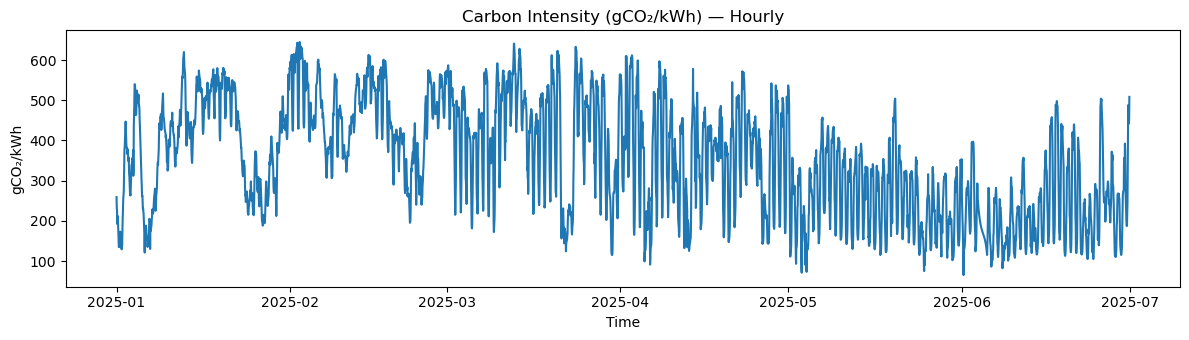

In [13]:
plt.figure(figsize=(12,3.5))
plt.plot(df_hourly.index, df_hourly['carbon_g_per_kwh'])
plt.title('Carbon Intensity (gCO₂/kWh) — Hourly')
plt.xlabel('Time'); plt.ylabel('gCO₂/kWh')
plt.tight_layout()
plt.show()

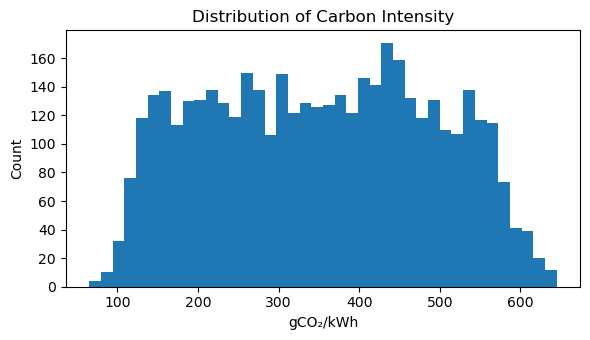

In [14]:
#Histogram for Outliers

plt.figure(figsize=(6,3.5))
plt.hist(df_hourly['carbon_g_per_kwh'], bins=40)
plt.title('Distribution of Carbon Intensity')
plt.xlabel('gCO₂/kWh'); plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [15]:
col = df_hourly['carbon_g_per_kwh']
q1, q3 = col.quantile(0.25), col.quantile(0.75)
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
mask_iqr = (col < low) | (col > high)
outlier_count = mask_iqr.sum()
print("Number of outliers found:", outlier_count)
print("Low threshold:", low)
print("High threshold:", high)

Number of outliers found: 0
Low threshold: -117.0
High threshold: 811.0


## Features (leakage-safe)

- Lags: `lag1`, `lag2`, `lag24` (all from **t−k**)  
- Rolling means: `roll24` (with **`.shift(1)`** so the window ends at **t−1**)  
- Calendar: hour, day-of-week, weekend, and sinusoidal encodings

> Note: rolling without `.shift(1)` would leak the target. We avoid that.


In [16]:
df_hourly = df_hourly.rename(columns={'carbon_g_per_kwh': 'y'})
df = df_hourly.copy()
df['hour'] = df.index.hour
df['dow'] = df.index.dayofweek
df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['sin_h'] = np.sin(2*np.pi*df['hour']/24)
df['cos_h'] = np.cos(2*np.pi*df['hour']/24)

# lags and rollings features
for L in [1, 2, 24]:
    df[f'lag{L}'] = df['y'].shift(L)
df['roll24']  = df['y'].rolling(24, min_periods=24).mean().shift(1)   
#df['roll168'] = df['y'].rolling(168).mean()

df = df.dropna()

In [17]:
df

,y,hour,dow,is_weekend,sin_h,cos_h,lag1,lag2,lag24,roll24
timestamp,,,,,,,,,,
2025-01-02 00:00:00+00:00,138.000000,0,3,0,0.000000,1.000000,142.000000,129.0,259.0,170.500000
2025-01-02 01:00:00+00:00,175.000000,1,3,0,0.258819,0.965926,138.000000,142.0,231.0,165.458333
2025-01-02 02:00:00+00:00,198.000000,2,3,0,0.500000,0.866025,175.000000,138.0,227.0,163.125000
2025-01-02 03:00:00+00:00,221.000000,3,3,0,0.707107,0.707107,198.000000,175.0,192.0,161.916667
2025-01-02 04:00:00+00:00,244.000000,4,3,0,0.866025,0.500000,221.000000,198.0,209.0,163.125000
...,...,...,...,...,...,...,...,...,...,...
2025-06-30 19:00:00+00:00,480.000000,19,0,0,-0.965926,0.258819,488.000000,416.0,264.0,292.958333
2025-06-30 20:00:00+00:00,453.000000,20,0,0,-0.866025,0.500000,480.000000,488.0,270.0,301.958333
2025-06-30 21:00:00+00:00,442.000000,21,0,0,-0.707107,0.707107,453.000000,480.0,274.0,309.583333


In [18]:
df.to_csv("data/engineered.csv")

## Split policy & baseline

- **Split (chronological):**  
  - **Train:** history up to *(Test−14 days)*  
  - **Validation:** 7 days  
  - **Test:** 7 days (final week; **never used** during tuning)

- **Baseline:** Seasonal naive at 24h — `ŷ(t) = y(t−24)`.  
This captures strong daily seasonality and is a fair comparator.


In [19]:
test_start = df.index.max() - pd.Timedelta(days=7)
val_start  = test_start - pd.Timedelta(days=7)

train = df[df.index <  val_start].copy()
val   = df[(df.index >= val_start) & (df.index < test_start)].copy()
test  = df[df.index >= test_start].copy()

In [20]:
train

,y,hour,dow,is_weekend,sin_h,cos_h,lag1,lag2,lag24,roll24
timestamp,,,,,,,,,,
2025-01-02 00:00:00+00:00,138.0,0,3,0,0.000000,1.000000e+00,142.0,129.0,259.0,170.500000
2025-01-02 01:00:00+00:00,175.0,1,3,0,0.258819,9.659258e-01,138.0,142.0,231.0,165.458333
2025-01-02 02:00:00+00:00,198.0,2,3,0,0.500000,8.660254e-01,175.0,138.0,227.0,163.125000
2025-01-02 03:00:00+00:00,221.0,3,3,0,0.707107,7.071068e-01,198.0,175.0,192.0,161.916667
2025-01-02 04:00:00+00:00,244.0,4,3,0,0.866025,5.000000e-01,221.0,198.0,209.0,163.125000
...,...,...,...,...,...,...,...,...,...,...
2025-06-16 18:00:00+00:00,353.0,18,0,0,-1.000000,-1.836970e-16,257.0,211.0,267.0,265.083333
2025-06-16 19:00:00+00:00,428.0,19,0,0,-0.965926,2.588190e-01,353.0,257.0,311.0,268.666667
2025-06-16 20:00:00+00:00,437.0,20,0,0,-0.866025,5.000000e-01,428.0,353.0,327.0,273.541667


In [21]:
val

,y,hour,dow,is_weekend,sin_h,cos_h,lag1,lag2,lag24,roll24
timestamp,,,,,,,,,,
2025-06-16 23:00:00+00:00,440.0,23,0,0,-0.258819,9.659258e-01,432.0,437.0,362.0,286.166667
2025-06-17 00:00:00+00:00,452.0,0,1,0,0.000000,1.000000e+00,440.0,432.0,375.0,289.416667
2025-06-17 01:00:00+00:00,455.0,1,1,0,0.258819,9.659258e-01,452.0,440.0,342.0,292.625000
2025-06-17 02:00:00+00:00,458.0,2,1,0,0.500000,8.660254e-01,455.0,452.0,342.0,297.333333
2025-06-17 03:00:00+00:00,457.0,3,1,0,0.707107,7.071068e-01,458.0,455.0,329.0,302.166667
...,...,...,...,...,...,...,...,...,...,...
2025-06-23 18:00:00+00:00,191.0,18,0,0,-1.000000,-1.836970e-16,168.0,179.0,211.0,172.708333
2025-06-23 19:00:00+00:00,233.0,19,0,0,-0.965926,2.588190e-01,191.0,168.0,221.0,171.875000
2025-06-23 20:00:00+00:00,240.0,20,0,0,-0.866025,5.000000e-01,233.0,191.0,244.0,172.375000


In [22]:
test

,y,hour,dow,is_weekend,sin_h,cos_h,lag1,lag2,lag24,roll24
timestamp,,,,,,,,,,
2025-06-23 23:00:00+00:00,258.000000,23,0,0,-0.258819,0.965926,257.000000,267.0,218.0,174.958333
2025-06-24 00:00:00+00:00,248.000000,0,1,0,0.000000,1.000000,258.000000,257.0,254.0,176.625000
2025-06-24 01:00:00+00:00,220.000000,1,1,0,0.258819,0.965926,248.000000,258.0,200.0,176.375000
2025-06-24 02:00:00+00:00,206.000000,2,1,0,0.500000,0.866025,220.000000,248.0,209.0,177.208333
2025-06-24 03:00:00+00:00,201.000000,3,1,0,0.707107,0.707107,206.000000,220.0,200.0,177.083333
...,...,...,...,...,...,...,...,...,...,...
2025-06-30 19:00:00+00:00,480.000000,19,0,0,-0.965926,0.258819,488.000000,416.0,264.0,292.958333
2025-06-30 20:00:00+00:00,453.000000,20,0,0,-0.866025,0.500000,480.000000,488.0,270.0,301.958333
2025-06-30 21:00:00+00:00,442.000000,21,0,0,-0.707107,0.707107,453.000000,480.0,274.0,309.583333


In [23]:
X_cols = [c for c in df.columns if c != 'y']
Xtr, ytr = train[X_cols].values, train['y'].values
Xva, yva = val[X_cols].values,   val['y'].values
Xte, yte = test[X_cols].values,  test['y'].values

In [24]:
# Basic baselines for model comparison and  data leakage check

b_mae_val  = mean_absolute_error(val['y'],  val['lag24'])
b_rmse_val = mean_squared_error(val['y'],  val['lag24'], squared=False)
b_mae_test = mean_absolute_error(test['y'], test['lag24'])
b_rmse_test= mean_squared_error(test['y'], test['lag24'], squared=False)
print("Validation baseline (lag-24): MAE", round(b_mae_val, 2), ", RMSE", round(b_rmse_val, 2))

Validation baseline (lag-24): MAE 52.57 , RMSE 69.56


## Model 1 — XGBoost (with validation random search)

- Random search on **Validation** (early stopping) to choose hyperparameters  
- Then retrain on **Train+Validation** and evaluate **once** on **Test**


**What it learns**  
A single model that predicts the *next hour*:  


**How it’s trained**
- Random search on **Train vs Val** with **early stopping** (older XGBoost: pass `early_stopping_rounds` to `.fit()`).
- Retrain on **Train+Val** with the selected hyper-parameters and the best number of trees (`best_iteration` / `best_ntree_limit`).

**How we evaluate**
- **One-step Test**: predict each hour using *true* past lags (what you would know in real time).  
- **Day-ahead**: to produce 24 hours, we **loop 24 times**. Each prediction becomes part of the history for the next step.

**Pros**
- One compact model; strong at very short horizons due to `lag1` persistence.
- Fast to train and deploy.
- Better at capturing trends

**Cons**
- **Error compounding**: if hour 1 is off, hours 2..24 can drift.
- One model must “be everything” for all horizons (no specialization for evening spikes, etc.).

**Best to use**
- While it works best for day-ahead forecasting, much better in the case of:
- **Nowcasting** (continuous rolling one-hour-ahead updates).
- Very tight compute budgets where simplicity is critical.

---


##  How to read plots

- **Next 24h (from last timestamp)**  
  Operational view: what we would supply to the API today. If available, we overlay the **previous recursive forecast** for a visual A/B.

- **Parity (pred vs true) & Residuals** *(elsewhere in the notebook)*  
  Points near the diagonal and centered residuals indicate good calibration. Long positive tails mean **under-prediction of peaks**—typical when we don’t use exogenous inputs (weather, generation mix, load).

---

##  Baseline & Metrics

- **Baseline**: seasonal naïve **t−24** (yesterday’s same hour).  
  It’s strong when daily patterns dominate; any model must beat it to be useful.

- **Metrics**: **MAE** (operationally interpretable, average absolute error in gCO₂/kWh) and **RMSE** (penalizes big misses—peaks).

- **Fairness**: chronological Train/Val/Test; Val only for tuning; Test held out; rollings end at t−1; targets are forward shifts (`y(t+h)` via `shift(-h)`).

---

##  Practical notes (why the results look the way they do)

- **Small, single-feature dataset**: all features are derived from `y`. XGB trains fast on **CPU**.  
- **Why `lag1` matters** (in 1-step): persistence is real; **not leakage** because `lag1` is `y(t−1)` at prediction time.    
- **Largest remaining errors**: sharp ramps/peaks with drivers outside `y`—these require **environment data** (wind/solar forecasts, load, imports/exports, prices, outages, holidays).

---

In [25]:
# XGBOOST

param_space = {
    'n_estimators':     [200,300, 500, 600, 800, 1200],
    'max_depth':        [3, 4, 6, 8],
    'learning_rate':    [0.02, 0.05,0.07, 0.1, 0.12],
    'subsample':        [0.6, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda':       [1.0, 2.0, 5.0],
    'min_child_weight': [1, 3, 5],
}
N_TRIALS = 200 

best_params, best_mae, best_rmse, best_n_estimators = None, None, None, None
for _ in range(N_TRIALS):
    params = {k: random.choice(v) for k, v in param_space.items()}
    model = XGBRegressor(objective='reg:squarederror',
    eval_metric='rmse',              # move here
    early_stopping_rounds=150,        # move here
    random_state=42,
    **params)
    model.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        verbose=False,
    )
    pred_val = model.predict(Xva)
    mae = mean_absolute_error(yva, pred_val)
    rmse = mean_squared_error(yva, pred_val, squared=False)
    if (best_mae is None) or (mae < best_mae):
        best_params = params
        best_mae, best_rmse = mae, rmse
        best_n_estimators = getattr(model, "best_iteration", params["n_estimators"])

print("Best on validation: MAE", round(best_mae, 2), ", RMSE", round(best_rmse, 2), ", params:", best_params)

Best on validation: MAE 13.49 , RMSE 19.96 , params: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_lambda': 2.0, 'min_child_weight': 5}


In [26]:
# Trained model

train_val = pd.concat([train, val])
Xtv, ytv = train_val[X_cols].values, train_val['y'].values

final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(Xtv, ytv)

pred_test = final_model.predict(Xte)
mae_test  = mean_absolute_error(yte, pred_test)
rmse_test = mean_squared_error(yte, pred_test, squared=False)

print("Test baseline (lag-24): MAE",b_mae_test, ", RMSE", b_rmse_test)
print("Test XGB: MAE", mae_test, ", RMSE", rmse_test)


Test baseline (lag-24): MAE 83.17253192151978 , RMSE 108.11979452003246
Test XGB: MAE 13.820314061043977 , RMSE 19.537994371341735


In [27]:
# Analysis

metrics = pd.DataFrame({ "MAE": [ b_mae_val, best_mae, b_mae_test, mae_test],
        "RMSE": [b_rmse_val, best_rmse, b_rmse_test, rmse_test],},
    index=["VAL: Baseline-24h", "VAL: XGB (best)",
           "TEST: Baseline-24h", "TEST: XGB (final)"]
)
metrics


,MAE,RMSE
VAL: Baseline-24h,52.565476,69.562793
VAL: XGB (best),13.491723,19.964706
TEST: Baseline-24h,83.172532,108.119795
TEST: XGB (final),13.820314,19.537994


## Evaluation (XGBoost)

We compare against the baseline on **Validation** and **Test**, then visualize:
- True vs Baseline vs XGB
- Feature importances
- Residuals over time & histogram
- Parity (Pred vs True)


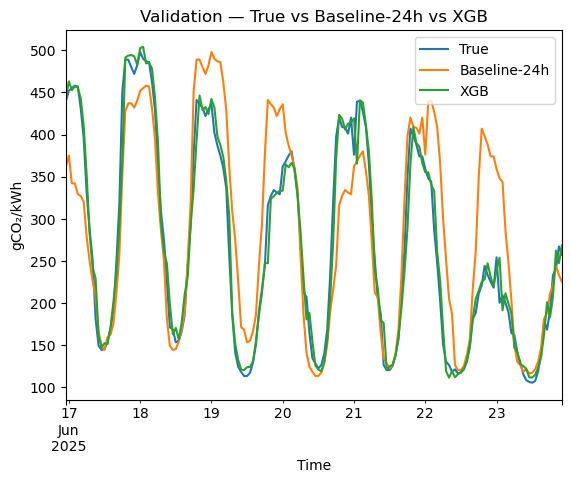

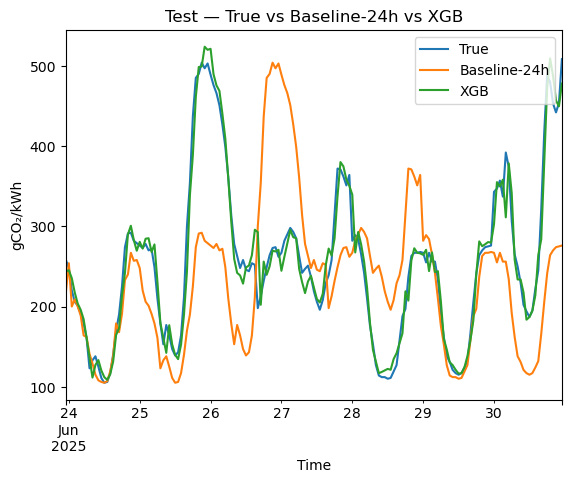

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

model_val = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)
model_val.fit(Xtr, ytr)
val_pred = model_val.predict(Xva)


val_baseline  = val['lag24'].values
test_baseline = test['lag24'].values


# Validation comparison

plt.figure()
pd.Series(val['y'].values, index=val.index, name="True").plot()
pd.Series(val_baseline, index=val.index, name="Baseline-24h").plot()
pd.Series(val_pred, index=val.index, name="XGB").plot()
plt.title("Validation — True vs Baseline-24h vs XGB")
plt.xlabel("Time"); plt.ylabel("gCO₂/kWh")
plt.legend()

# Test comparison

plt.figure()
pd.Series(test['y'].values, index=test.index, name="True").plot()
pd.Series(test_baseline, index=test.index, name="Baseline-24h").plot()
pd.Series(pred_test, index=test.index, name="XGB").plot()
plt.title("Test — True vs Baseline-24h vs XGB")
plt.xlabel("Time"); plt.ylabel("gCO₂/kWh")
plt.legend()

plt.show()



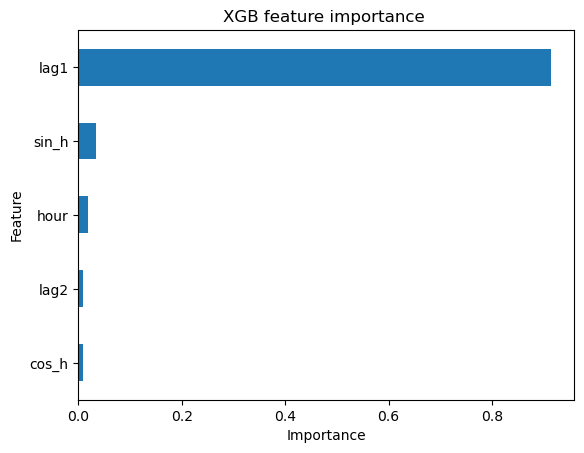

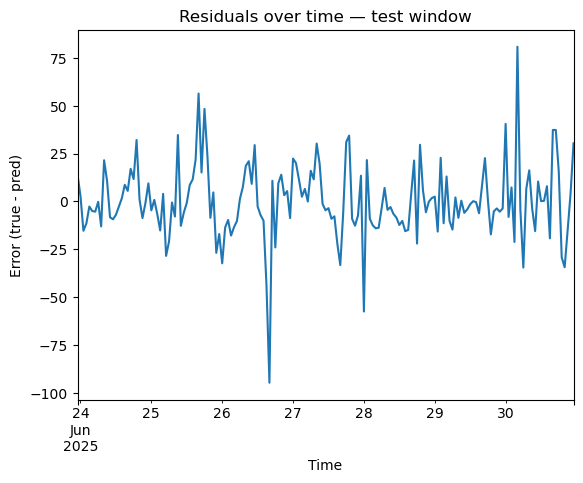

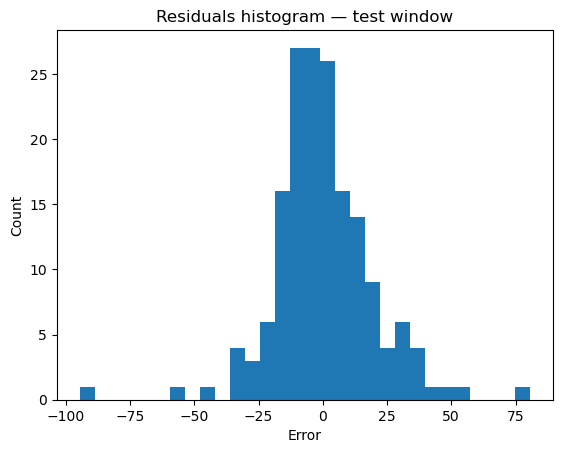

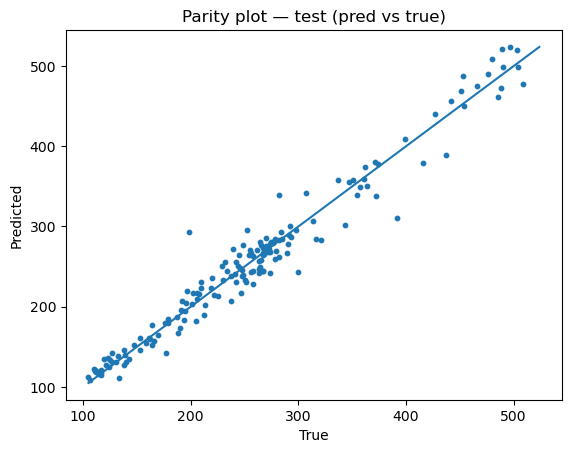

In [29]:

# Feature importances 

imp = pd.Series(final_model.feature_importances_, index=X_cols).sort_values(ascending=False).head()
plt.figure()
imp.iloc[::-1].plot(kind="barh")
plt.title("XGB feature importance ")
plt.xlabel("Importance"); plt.ylabel("Feature")


# Residuals on test

res = pd.Series(yte - pred_test, index=test.index, name="residuals")

plt.figure()
res.plot()
plt.title("Residuals over time — test window")
plt.xlabel("Time"); plt.ylabel("Error (true - pred)")

plt.figure()
plt.hist(res.values, bins=30)
plt.title("Residuals histogram — test window")
plt.xlabel("Error"); plt.ylabel("Count")


# Parity plot

y_true = pd.Series(yte, index=test.index)
y_pred = pd.Series(pred_test, index=test.index)
mn = float(min(y_true.min(), y_pred.min()))
mx = float(max(y_true.max(), y_pred.max()))

plt.figure()
plt.scatter(y_true.values, y_pred.values, s=10)
plt.plot([mn, mx], [mn, mx])
plt.title("Parity plot — test (pred vs true)")
plt.xlabel("True"); plt.ylabel("Predicted")

plt.show()

## Next-24h forecast (XGB, recursive)

We generate a 24-hour forecast from the last observed timestamp by recomputing features each hour from predicted history (accepting some error propagation). For production we could use **direct multi-horizon** models to avoid compounding.


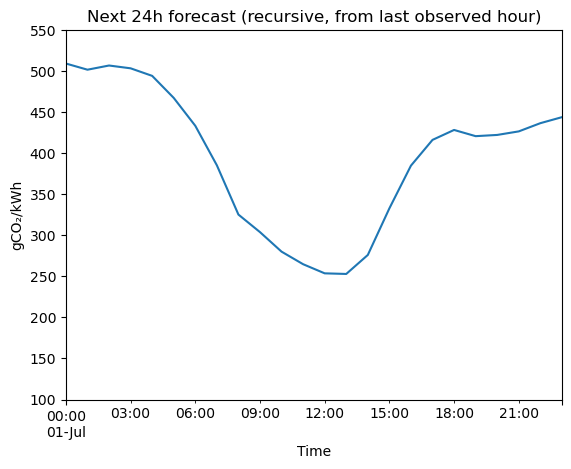

In [30]:

import pickle

state = df.copy()  
future_vals = []
future_times = []

for step in range(24):
    next_idx = state.index[-1] + pd.Timedelta(hours=1)
    row = {}

    if 'hour' in X_cols:        row['hour'] = next_idx.hour
    if 'dow' in X_cols:         row['dow'] = next_idx.dayofweek
    if 'is_weekend' in X_cols:  row['is_weekend'] = 1 if row.get('dow', next_idx.dayofweek) >= 5 else 0
    if 'sin_h' in X_cols:       row['sin_h'] = np.sin(2*np.pi*next_idx.hour/24)
    if 'cos_h' in X_cols:       row['cos_h'] = np.cos(2*np.pi*next_idx.hour/24)

    if 'lag1' in X_cols:        row['lag1'] = state['y'].iloc[-1]
    if 'lag2' in X_cols and len(state) >= 2:    row['lag2'] = state['y'].iloc[-2]
    if 'lag24' in X_cols and len(state) >= 24:  row['lag24'] = state['y'].iloc[-24]
    #if 'lag168' in X_cols and len(state) >= 168:row['lag168'] = state['y'].iloc[-168]

    # rolling means from past only
    if 'roll24' in X_cols and len(state) >= 24:
        row['roll24'] = state['y'].iloc[-24:].mean()
    #if 'roll168' in X_cols and len(state) >= 168:
        row['roll168'] = state['y'].iloc[-168:].mean()

    x_next = pd.DataFrame([row], index=[next_idx])[X_cols]
    yhat = float(final_model.predict(x_next))

    future_vals.append(yhat)
    future_times.append(next_idx)

    row['y'] = yhat
    state = pd.concat([state, pd.DataFrame([row], index=[next_idx])], sort=False)

pickle.dump(final_model, open("model.pkl", "wb"))

forecast_24h = pd.Series(future_vals, index=pd.DatetimeIndex(future_times), name='forecast_24h')

# plot
import matplotlib.pyplot as plt
forecast_24h.plot()
plt.ylim(bottom=100)
plt.ylim(top=550)
plt.title("Next 24h forecast")
plt.xlabel("Time"); plt.ylabel("gCO₂/kWh")
plt.show()


## Another possible approach — Direct Multi-Horizon XGBoost (Not in this notebook)

 
**24 separate models**  **directly from history up to t**:  

We add **target-time calendar features** for the future hour:  
`hour_h`, `dow_h`, `we_h`, `sin_h_h`, `cos_h_h` computed **from t+h** (this is allowed—time is known).

**How it’s trained**
- Tune on **h=1** (Train vs Val) with early stopping → get robust hyper-params and `best_n_estimators`.
- Train **24 models** on **Train+Val** with those fixed params (`n_estimators = best`).

**How we evaluate**
- **Day-ahead on Test**: for each test day, build the 24-hour vector using history up to **t0 = day_start − 1 h**.  
  No predictions are fed back; each hour is predicted by its own horizon model.

**Pros**
- **No error propagation** across the 24 hours.
- **Horizon specialization**: h=18 learns evening peaks; h=3 learns night valleys.
- Often **more stable day-ahead curves** versus recursive.

**Cons** 
- Not good at capturing trends.
- 24 parallel models to store.
- Slightly more code.

# Model 2 — Multi-Input Neural Network (MINN)

This is a **sequence model** that learns from multiple look-back windows of the **same target series** to forecast hourly carbon intensity. We use three inputs capturing **daily**, **weekly**, and **monthly** context and predict the **next hour**.

---


### Multi-input windows (all end at *t−1*, so no leakage)
- **Daily branch**: last **24** hours → shape `(24, 1)`  
- **Weekly branch**: last **168** hours → shape `(168, 1)`  
- **Monthly branch**: last **672** hours → shape `(672, 1)`  

> Earliest usable target is **t = 672** (after enough history accumulates). Each training sample predicts **y(t)** from windows \[t−24..t−1], \[t−168..t−1], \[t−672..t−1].

---

##  Architecture (CPU-friendly)

Three parallel sequence encoders, then fusion:

- **Daily**: `LSTM(16, return_sequences=True)` → `GlobalAveragePooling1D` → `Dense(8, relu)`  
- **Weekly**: `LSTM(16, return_sequences=True)` → `GlobalAveragePooling1D` → `Dense(8, relu)`  
- **Monthly**: `LSTM(16, return_sequences=True)` → `GlobalAveragePooling1D` → `Dense(8, relu)`  
- **Fusion**: `Concatenate` → `Dense(32, relu)` → `Dropout(0.2)` → `Dense(16, relu)` → **`Dense(1, linear)`** (predicts next hour, scaled units)

---

## Training & Evaluation

- **Splits (chronological)**: Train → **Validation (7d)** → **Test (7d)**.  
- **Loss/Optimizer**: MSE with **Adam(1e-3)**; monitor `val_loss`.
- **Callbacks**: `EarlyStopping(patience=~10-12, restore_best_weights=True)`, `ReduceLROnPlateau`.
- **Scaling discipline**: scaler **fit on Train only**; predictions inverse-scaled before scoring.
- **One-step Test**: predict **y(t)** using the three windows ending at **t−1** (no future context).  

---


## Strengths & Limitations (in this dataset)

**Strengths**
- **Multiple time scales** (24/168/672h) captured jointly; can model slow trends + daily shape.
- Works with **only the target series**; CPU-friendly; quick to train.

**Limitations**
- With a **small, univariate** dataset, gains over a tuned tree model can be modest.
- Peaks remain challenging without exogenous drivers.

---



In [31]:
df_hourly

,y
timestamp,
2025-01-01 00:00:00+00:00,259.000000
2025-01-01 01:00:00+00:00,231.000000
2025-01-01 02:00:00+00:00,227.000000
2025-01-01 03:00:00+00:00,192.000000
2025-01-01 04:00:00+00:00,209.000000
...,...
2025-06-30 19:00:00+00:00,480.000000
2025-06-30 20:00:00+00:00,453.000000
2025-06-30 21:00:00+00:00,442.000000


In [32]:
# Make hourly series safe for asfreq(): sort, then regularize

s = df_hourly['y'].astype(float).copy()

s.index = pd.to_datetime(s.index, utc=True)        
s = s.sort_index()

if s.index.duplicated().any():
    # Option A: keep last occurrence
    s = s[~s.index.duplicated(keep='last')]
    
s = s.asfreq('H')                                   
s = s.interpolate(limit_direction='both')           


In [33]:
y_series=s

In [34]:
# MINN (Multi-Input NN) for y

import numpy as np, pandas as pd, matplotlib.pyplot as plt, random, tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import layers, models, callbacks, optimizers


SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
if getattr(y_series.index, "tz", None) is not None:
    y_series.index = y_series.index.tz_convert('UTC').tz_localize(None)

test_start = y_series.index.max() - pd.Timedelta(days=7)
val_start  = test_start - pd.Timedelta(days=7)

scaler = StandardScaler()
scaler.fit(y_series.loc[:val_start - pd.Timedelta(hours=1)].values.reshape(-1,1))

L_D, L_W, L_M = 24, 168, 168*4  # daily, weekly, monthly lengths

y_scaled = pd.Series(
    scaler.transform(y_series.values.reshape(-1,1)).ravel(),
    index=y_series.index
)

times = y_scaled.index
maxL  = L_M  # longest window controls the first usable target index
Xs_d, Xs_w, Xs_m, Ys, Ts = [], [], [], [], []

for i in range(maxL, len(y_scaled)):  # predict y(t_i) from past windows up to t_{i-1}
    t  = times[i]
    Xd = y_scaled.iloc[i-L_D:i].values.reshape(L_D, 1)
    Xw = y_scaled.iloc[i-L_W:i].values.reshape(L_W, 1)
    Xm = y_scaled.iloc[i-L_M:i].values.reshape(L_M, 1)
    y  = y_scaled.iloc[i]  # target (scaled)
    Xs_d.append(Xd); Xs_w.append(Xw); Xs_m.append(Xm); Ys.append(y); Ts.append(t)

Xs_d = np.array(Xs_d); Xs_w = np.array(Xs_w); Xs_m = np.array(Xs_m)
Ys   = np.array(Ys).reshape(-1,1); Ts = np.array(Ts)



In [35]:

mask_val  = (Ts >= np.datetime64(val_start)) & (Ts < np.datetime64(test_start))
mask_test = (Ts >= np.datetime64(test_start))
mask_train= (Ts <  np.datetime64(val_start))

Xd_tr, Xw_tr, Xm_tr, y_tr = Xs_d[mask_train], Xs_w[mask_train], Xs_m[mask_train], Ys[mask_train]
Xd_va, Xw_va, Xm_va, y_va = Xs_d[mask_val ], Xs_w[mask_val ], Xs_m[mask_val ], Ys[mask_val ]
Xd_te, Xw_te, Xm_te, y_te = Xs_d[mask_test], Xs_w[mask_test], Xs_m[mask_test], Ys[mask_test]
Ts_te = Ts[mask_test]

print("Train:", Xd_tr.shape, " Val:", Xd_va.shape, " Test:", Xd_te.shape)


def make_minn(ld=L_D, lw=L_W, lm=L_M):
    # Daily
    inp_d = layers.Input(shape=(ld,1), name="daily_input")
    d = layers.LSTM(64, return_sequences=True)(inp_d)
    d = layers.GlobalAveragePooling1D()(d)
    d = layers.Dense(32, activation="relu")(d)

    # Weekly
    inp_w = layers.Input(shape=(lw,1), name="weekly_input")
    w = layers.LSTM(16, return_sequences=True)(inp_w)
    w = layers.GlobalAveragePooling1D()(w)
    w = layers.Dense(32, activation="relu")(w)

    # Monthly
    inp_m = layers.Input(shape=(lm,1), name="monthly_input")
    m = layers.LSTM(32, return_sequences=True)(inp_m)
    m = layers.GlobalAveragePooling1D()(m)
    m = layers.Dense(32, activation="relu")(m)

    z = layers.Concatenate()([d,w,m])
    z = layers.Dense(32, activation="relu")(z)
    z = layers.Dropout(0.2)(z)
    z = layers.Dense(16, activation="relu")(z)
    out = layers.Dense(1, activation="linear", name="y_next")(z)

    model = models.Model(inputs=[inp_d, inp_w, inp_m], outputs=out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
    return model

model = make_minn()

early = callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
reduce= callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5)



Train: (3335, 24, 1)  Val: (168, 24, 1)  Test: (169, 24, 1)


In [36]:

hist = model.fit(
    [Xd_tr, Xw_tr, Xm_tr], y_tr,
    validation_data=([Xd_va, Xw_va, Xm_va], y_va),
    epochs=200, batch_size=24, verbose=1,
    callbacks=[early, reduce]
)



Epoch 1/200
139/139 [==============================] - 7s 26ms/step - loss: 0.5677 - val_loss: 0.6608 - lr: 0.0010
Epoch 2/200
139/139 [==============================] - 3s 21ms/step - loss: 0.4285 - val_loss: 0.3838 - lr: 0.0010
Epoch 3/200
139/139 [==============================] - 3s 21ms/step - loss: 0.2740 - val_loss: 0.1969 - lr: 0.0010
Epoch 4/200
139/139 [==============================] - 3s 21ms/step - loss: 0.2018 - val_loss: 0.1510 - lr: 0.0010
Epoch 5/200
139/139 [==============================] - 3s 22ms/step - loss: 0.1532 - val_loss: 0.1078 - lr: 0.0010
Epoch 6/200
139/139 [==============================] - 3s 22ms/step - loss: 0.1382 - val_loss: 0.0727 - lr: 0.0010
Epoch 7/200
139/139 [==============================] - 3s 21ms/step - loss: 0.1198 - val_loss: 0.0744 - lr: 0.0010
Epoch 8/200
139/139 [==============================] - 3s 21ms/step - loss: 0.1038 - val_loss: 0.0542 - lr: 0.0010
Epoch 9/200
139/139 [==============================] - 3s 22ms/step - loss: 0.09

MINN — TEST  MAE=16.51  RMSE=22.51


(100.0, 528.5921052631579)

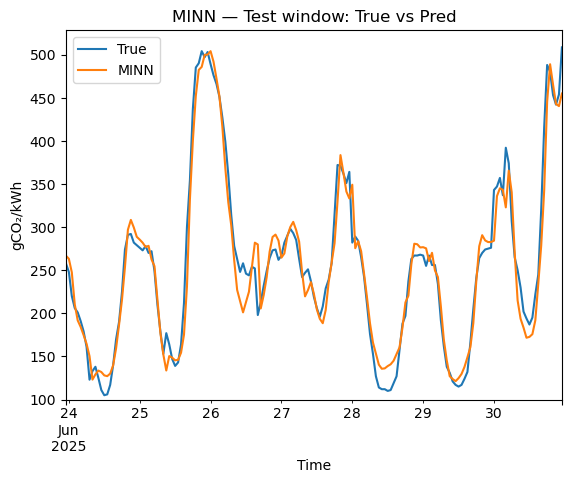

In [37]:

y_pred_te_s = model.predict([Xd_te, Xw_te, Xm_te], verbose=0).ravel()
y_true_te   = scaler.inverse_transform(y_te).ravel()
y_pred_te   = scaler.inverse_transform(y_pred_te_s.reshape(-1,1)).ravel()

mae_minn  = mean_absolute_error(y_true_te, y_pred_te)
rmse_minn = mean_squared_error(y_true_te, y_pred_te, squared=False)
print(f"MINN — TEST  MAE={mae_minn:.2f}  RMSE={rmse_minn:.2f}")

plt.figure()
pd.Series(y_true_te, index=Ts_te, name="True").plot()
pd.Series(y_pred_te, index=Ts_te, name="MINN").plot()
plt.title("MINN — Test window: True vs Pred")
plt.xlabel("Time"); plt.ylabel("gCO₂/kWh"); plt.legend(); plt.ylim(bottom=100)



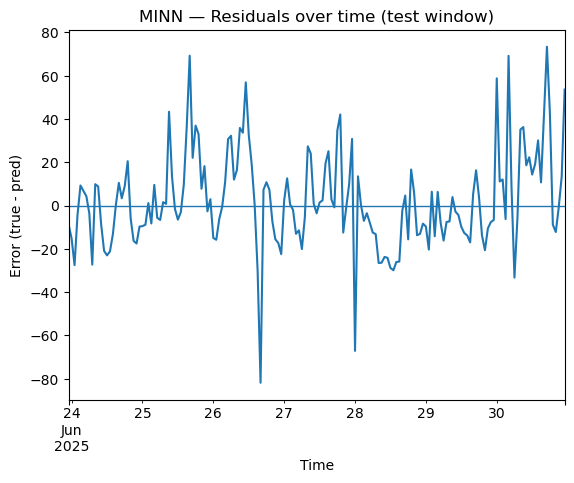

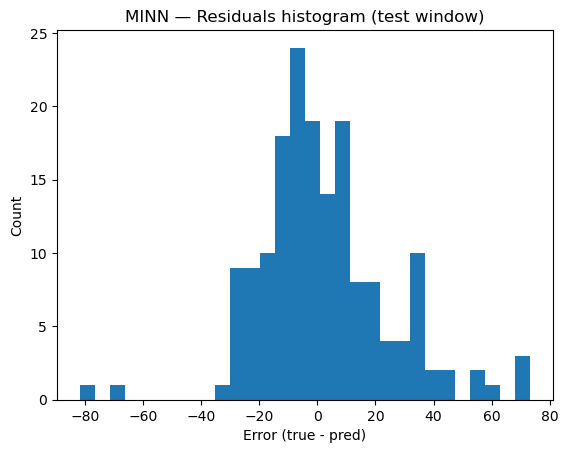

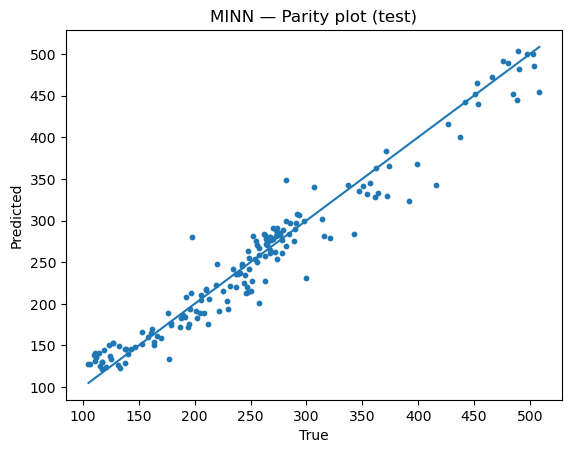

In [38]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Ensure we have aligned timestamps for the test predictions
ts_index = pd.to_datetime(Ts_te)  # Ts_te came from your window builder
# If Ts_te is timezone-aware in some environments, make it tz-naive
if getattr(ts_index.tz, "zone", None) is not None:
    ts_index = ts_index.tz_convert('UTC').tz_localize(None)

# Residuals: true - pred (original units)
res_minn = pd.Series(y_true_te - y_pred_te, index=ts_index, name="residuals_minn")

# --------------------------
# 1) Residuals over time
# --------------------------
plt.figure()
res_minn.plot()
plt.title("MINN — Residuals over time (test window)")
plt.xlabel("Time"); plt.ylabel("Error (true - pred)")
plt.axhline(0.0, linewidth=1)
plt.show()

# --------------------------
# 2) Residuals histogram
# --------------------------
plt.figure()
plt.hist(res_minn.values, bins=30)
plt.title("MINN — Residuals histogram (test window)")
plt.xlabel("Error (true - pred)"); plt.ylabel("Count")
plt.show()

# --------------------------
# 3) Parity plot (pred vs true)
# --------------------------
y_true_s = pd.Series(y_true_te, index=ts_index)
y_pred_s = pd.Series(y_pred_te, index=ts_index)

mn = float(min(y_true_s.min(), y_pred_s.min()))
mx = float(max(y_true_s.max(), y_pred_s.max()))

plt.figure()
plt.scatter(y_true_s.values, y_pred_s.values, s=10)
plt.plot([mn, mx], [mn, mx])
plt.title("MINN — Parity plot (test)")
plt.xlabel("True"); plt.ylabel("Predicted")
plt.show()


## Next-24h forecast (MINN, recursive)

Same setup as XGB but with the three sequence inputs. In production, a **direct 24-h block** approach (one head per horizon) can avoid error propagation.


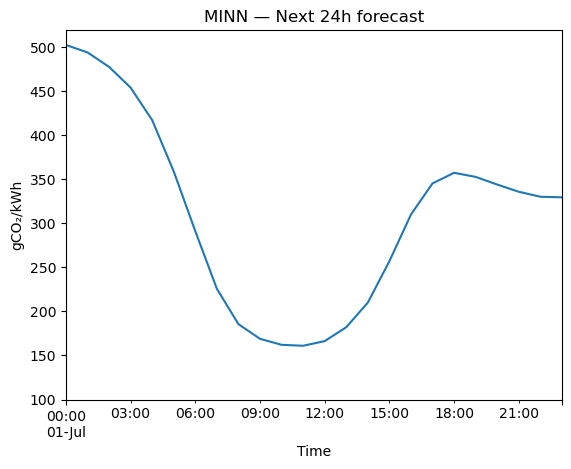

In [39]:

y_hist_raw = y_series.copy()                      # raw units
y_hist_s   = pd.Series(scaler.transform(y_hist_raw.values.reshape(-1,1)).ravel(),
                       index=y_hist_raw.index)    # scaled units

future_vals_raw, future_times = [], []
cur_index = y_hist_s.index[-1]

for h in range(24):
    next_t = cur_index + pd.Timedelta(hours=1)

    # build windows from the SCALED history up to current (t)
    Xd = y_hist_s.iloc[-L_D:].values.reshape(1, L_D, 1)
    Xw = y_hist_s.iloc[-L_W:].values.reshape(1, L_W, 1)
    Xm = y_hist_s.iloc[-L_M:].values.reshape(1, L_M, 1)

    yhat_s = float(model.predict([Xd, Xw, Xm], verbose=0))
    yhat   = float(scaler.inverse_transform([[yhat_s]]))  # back to original units

    # append to history for the next step (scaled & raw)
    y_hist_s = pd.concat([y_hist_s, pd.Series([yhat_s], index=[next_t])])
    y_hist_raw = pd.concat([y_hist_raw, pd.Series([yhat], index=[next_t])])

    future_vals_raw.append(yhat)
    future_times.append(next_t)
    cur_index = next_t

forecast_24h_minn = pd.Series(future_vals_raw, index=pd.DatetimeIndex(future_times), name="MINN_forecast")

plt.figure()
ax = forecast_24h_minn.plot()
ax.set_ylim(100, None)
plt.title("MINN — Next 24h forecast")
plt.xlabel("Time"); plt.ylabel("gCO₂/kWh")
plt.show()

## Test window — XGBoost vs MINN vs True (aligned)

We align timestamps and compute MAE/RMSE on the same hours for a fair comparison.


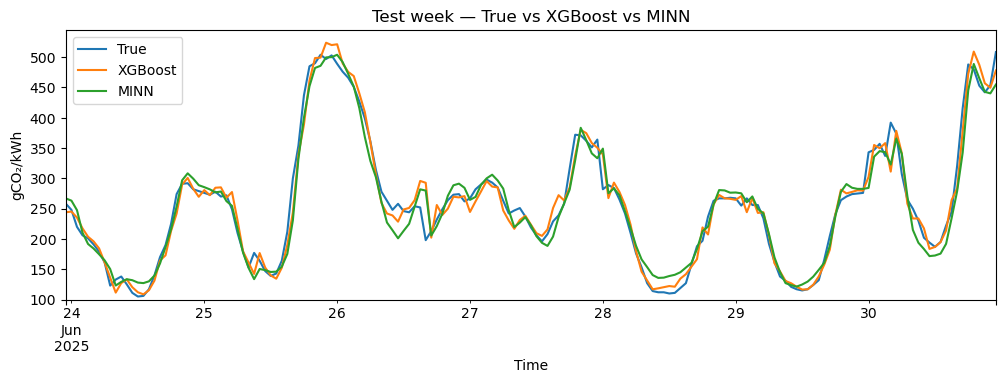

,MAE,RMSE
XGBoost,13.82,19.54
MINN,16.51,22.51


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- make all indexes tz-naive (UTC) so they can be joined ---
idx_test = pd.DatetimeIndex(test.index)
if idx_test.tz is not None:
    idx_test = idx_test.tz_convert('UTC').tz_localize(None)

idx_minn = pd.DatetimeIndex(Ts_te)  # Ts_te from MINN
if idx_minn.tz is not None:
    idx_minn = idx_minn.tz_convert('UTC').tz_localize(None)

# --- series for each model on test window ---
true_test = pd.Series(test['y'].values, index=idx_test, name="True")
xgb_test  = pd.Series(pred_test,        index=idx_test, name="XGBoost")
minn_test = pd.Series(y_pred_te,        index=idx_minn, name="MINN")

# align on common timestamps only (inner join), then sort
cmp = pd.concat([true_test, xgb_test, minn_test], axis=1, join='inner').sort_index()

# ---------- Plot: Test week — Actual vs XGB vs MINN ----------
plt.figure(figsize=(12,3.5))
cmp["True"].plot()
cmp["XGBoost"].plot()
cmp["MINN"].plot()
plt.title("Test week — True vs XGBoost vs MINN")
plt.xlabel("Time"); plt.ylabel("gCO₂/kWh"); plt.legend()
plt.ylim(bottom=100)   # start y-axis at 100
plt.show()

# ---------- Metrics table (on aligned timestamps) ----------
mae_xgb  = mean_absolute_error(cmp["True"], cmp["XGBoost"])
rmse_xgb = mean_squared_error(cmp["True"], cmp["XGBoost"], squared=False)
mae_minn  = mean_absolute_error(cmp["True"], cmp["MINN"])
rmse_minn = mean_squared_error(cmp["True"], cmp["MINN"], squared=False)

metrics_compare = pd.DataFrame(
    {"MAE": [mae_xgb, mae_minn], "RMSE": [rmse_xgb, rmse_minn]},
    index=["XGBoost", "MINN"]
).round(2)

metrics_compare


In [41]:
metrics_compare = pd.DataFrame(
    {
        "MAE":  [b_mae_test, mae_test, mae_minn],
        "RMSE": [b_rmse_test, rmse_test, rmse_minn],
    },
    index=["Baseline (t-24)", "XGBoost", "MINN"]
).round(2)
metrics_compare


,MAE,RMSE
Baseline (t-24),83.17,108.12
XGBoost,13.82,19.54
MINN,16.51,22.51


## Discussion & Conclusions

**What makes this easy or hard?**

- **Easy:**
- High persistence: strong autocorrelation → lag1 dominates feature importance (one-step-ahead uses the last hour you already know).
- Small, clean dataset (~4.3k hours) and one target signal → fast training/inference on CPU (both XGBoost and MINN).

- **Hard:**
- Ramps & peaks: sharp evening spikes (seen in residual time plot and parity scatter’s upper tail) are poorly predicted without external drivers.
- Multi-month trend, and holiday effects can shift the baseline abruptly.
- Univariate limitation: with only y, models must infer weather & generation mix indirectly; limited ability to anticipate sudden changes.
---

**What could make results more accurate?**  

- Add exogenous drivers (see next section): wind/solar forecasts, load, generation mix, imports/exports, temperature, prices.
- Direct multi-horizon training for day-ahead: so each hour h uses only history up to time t, not earlier predictions → avoids error compounding and      captures horizon-specific behavior (e.g., evening peaks).
- Weekly memory & robust features: include lag168, roll168, rolling std/volatility, holiday flags.
- **Better loss/objective for peaks**: Standard loss functions like MSE or RMSE treat all errors equally, whether you underpredict a low value (e.g.,   120 gCO₂/kWh) or a high one (e.g., 520 gCO₂/kWh). But high carbon intensity hours are more critical operationally as they contribute more to     emissions and policy violations. So weighted RMSE or quantile (pinball) loss can be used to emphasize high carbon intensity hours that matter operationally.
- Ensembles: blend baseline (t-24), XGB, and a small NN; per-horizon ensembling often improves stability.
- Proper backtesting: sliding-window cross-validation across weeks to pick hyperparameters that generalize.
  like: Week 1–3 → train  
        Week 4   → validation  
        Week 5–7 → train  
        Week 8   → validation
---

**What other methods would you consider if this were production?**  

- LightGBM / XGBoost: Gradient-boosted decision trees scale well with exogenous variables (e.g., weather, demand, generation mix) and provide strong performance with relatively low tuning effort.
- **Neural Networks (when exogenous & temporal data are rich):**
- N-BEATS: Deep backcast-forecast models that perform well in time series benchmarks, especially for deterministic multi-horizon forecasting.
- TFT (Temporal Fusion Transformer): Powerful for multi-horizon prediction when many covariates are involved, combining attention, gating, and quantile loss.
- **Probabilistic Forecasting (crucial for operational decision-making):**

In real-world operations, point forecasts are not enough; therefore, grid operators, markets, and optimizers need uncertainty quantification to make risk-aware decisions.
- Quantile Regression: Produces multiple percentiles (P10, P50, P90), giving a range of likely outcomes.
NGBoost: A gradient boosting framework that directly models predictive distributions, not just mean values.
- Deep Probabilistic Models (TFT with quantile loss): Provide full forecast distributions, enabling scenario-based dispatching, confidence bands for CI, and robust reserve scheduling.

---



**Other methods to consider in production:**  
- LightGBM/CatBoost with exogenous features; linear ridge/Lasso per horizon; SARIMAX as transparent baseline; TFT/TCN/N-BEATS/NHITS with drivers; simple model stacking.

**Key drivers of carbon intensity:**  
- Generation mix (renewables vs fossil), demand level/ramps, weather, imports/exports, fuel prices.

**Sources of inaccuracy:**  
- Errors in exogenous forecasts, unmodelled events (outages/maintenance), holidays & DST transitions, regime changes.


## Part 2: Web Service Integration

In [42]:
dfc=df_hourly.rename(columns={"carbon_g_per_kwh": "y"})

In [43]:
dfc

,y
timestamp,
2025-01-01 00:00:00+00:00,259.000000
2025-01-01 01:00:00+00:00,231.000000
2025-01-01 02:00:00+00:00,227.000000
2025-01-01 03:00:00+00:00,192.000000
2025-01-01 04:00:00+00:00,209.000000
...,...
2025-06-30 19:00:00+00:00,480.000000
2025-06-30 20:00:00+00:00,453.000000
2025-06-30 21:00:00+00:00,442.000000


In [226]:
from pymongo import MongoClient
import pandas as pd

# 1. Connect to MongoDB local instance (adjust port if different)
client = MongoClient("mongodb://localhost:27017/")

# 2. Select the database and collection
db = client["Task1_Forecasting"]
collection = db["historical_data"]

# 3. Reset collection to avoid duplicates
collection.drop()

# 4. Prepare data: assume df_hourly exists and has a UTC datetime index and 'y' column
records = []
for timestamp, row in dfc.iterrows():
    records.append({
        "timestamp": timestamp.to_pydatetime(),
        "value": float(row['y'])  # Ensure float not numpy.float32
    })

# 5. Insert data
collection.insert_many(records)

print(f"Inserted {len(records)} documents into 'historical_data' collection.")


Inserted 4344 documents into 'historical_data' collection.
